# AlexNet

One of the most popular CNN models. Here I use CIFAR10

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import random
import os
import time
import cv2

np.random.seed(seed=1)

In [27]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

cifar10_train = datasets.CIFAR10('../data/CIFAR10', download=True, train=True, transform=transform)
cifar10_test = datasets.CIFAR10('../data/CIFAR10', download=True, train=False, transform=transform)
train_iter = DataLoader(cifar10_train, 500, shuffle=True)
test_iter = DataLoader(cifar10_test, 100, shuffle=False)
# for X,Y in train_iter:
#     print(X.shape, Y.shape)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
net = torch.nn.Sequential(
    nn.Conv2d(3, 18, kernel_size=5, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(18, 36, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(36, 54, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(54, 54, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(54, 36, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(36*6*6, 864),
    nn.ReLU(),
    nn.Linear(864, 384),
    nn.ReLU(),
    nn.Linear(384, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

X = torch.rand(size=(10, 3, 32, 32), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

Conv2d output shape: 	 torch.Size([10, 18, 28, 28])
ReLU output shape: 	 torch.Size([10, 18, 28, 28])
MaxPool2d output shape: 	 torch.Size([10, 18, 13, 13])
Conv2d output shape: 	 torch.Size([10, 36, 13, 13])
ReLU output shape: 	 torch.Size([10, 36, 13, 13])
Conv2d output shape: 	 torch.Size([10, 54, 13, 13])
ReLU output shape: 	 torch.Size([10, 54, 13, 13])
Conv2d output shape: 	 torch.Size([10, 54, 13, 13])
ReLU output shape: 	 torch.Size([10, 54, 13, 13])
Conv2d output shape: 	 torch.Size([10, 36, 13, 13])
ReLU output shape: 	 torch.Size([10, 36, 13, 13])
MaxPool2d output shape: 	 torch.Size([10, 36, 6, 6])
Flatten output shape: 	 torch.Size([10, 1296])
Linear output shape: 	 torch.Size([10, 864])
ReLU output shape: 	 torch.Size([10, 864])
Linear output shape: 	 torch.Size([10, 384])
ReLU output shape: 	 torch.Size([10, 384])
Linear output shape: 	 torch.Size([10, 64])
ReLU output shape: 	 torch.Size([10, 64])
Linear output shape: 	 torch.Size([10, 10])


In [29]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [30]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [31]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device("cpu")

In [32]:
# We compute classification accuracy on the current batch
# and add this metric to the accumulator, for plotting purposes


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, axis=1)
    cmp_ = y_hat.type(y.dtype) == y
    return float(cmp_.type(y.dtype).sum())

In [33]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print("training on", device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.0001)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel="epoch", xlim=[1, (num_epochs-1)*len(train_iter)], legend=["train loss", "train acc", "test acc"])
    timer, num_batches = Timer(), len(train_iter)
    counter = 0
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            # print(X.shape,y.shape)
            counter += 1
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            # print(y_hat.shape)
            # print(y.shape)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(counter, (train_l, train_acc, None))
            # print(epoch + (i + 1)/ num_batches , (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(counter, (None, None, test_acc))
    print(f"loss {train_l:.3f}, train acc {train_acc:.3f}, " f"test acc {test_acc:.3f}")
    print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec " f"on {str(device)}")

loss 0.518, train acc 0.820, test acc 0.578
1013.0 examples/sec on cpu


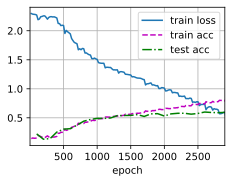

In [34]:
lr, num_epochs = 0.1, 30
train(net, train_iter, test_iter, num_epochs, lr, try_gpu())

1 : [('ship', 6.021934509277344), ('car', 4.86798620223999), ('truck', 2.1534037590026855)]
2 : [('deer', 6.743833541870117), ('horse', 3.779362678527832), ('dog', 2.599799394607544)]
3 : [('ship', 6.493801593780518), ('plane', 2.5060925483703613), ('frog', 2.4307191371917725)]
4 : [('truck', 5.486998558044434), ('car', 3.7341649532318115), ('dog', 3.606607675552368)]
5 : [('truck', 5.952204704284668), ('car', 2.6739494800567627), ('frog', 1.7439910173416138)]


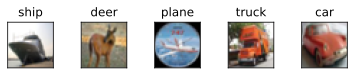

In [38]:
net.eval()
class_names = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i in range(5):
    index = random.randint(0,len(cifar10_test))
    input = torch.unsqueeze(cifar10_test[index][0],0)
    top_k = torch.topk(net(input),3)
    print(f'{i+1} : {[(class_names[i],prob) for i,prob in zip(top_k.indices.tolist()[0],top_k.values.tolist()[0])]}')
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_test[index][0].permute(1,2,0))
    plt.title(class_names[cifar10_test[index][1]])
    # plt.title(image_net_train_dataset.img_labels[image_net_test_dataset[index][1]])
plt.show()